# Decision Tree Model

In [1]:
execution_mode = 'full'

## Table of Contents

- [Data Takeover](#Data-Takeover)
- [Decision-Tree Classifier](#Decision-Tree-Classifier)
    - [Train/Test Split for Decision Tree](#Train/Test-Split-for-Decision-Tree)
    - [Model Training for Decision Tree](#Model-Training-for-Decision-Tree)
    - [Performance Measurement of Decision Tree](#Performance-Measurement-of-Decision-Tree)
- [Decision Tree Classifier with Cross-Validation](#Decision-Tree-Classifier-with-Cross-Validation)
    - [Train/Test Split for Decision Tree CV](#Train/Test-Split-for-Decision-Tree-CV)
    - [Model Training for Decision Tree CV](#Model-Training-for-Decision-Tree-CV)
    - [Performance Measurement of Decision Tree CV](#Performance-Measurement-of-Decision-Tree-CV)
- [Random Forests](#Random-Forests)
    - [Train/Test Split for Random Forests](#Train/Test-Split-for-Random-Forests)
    - [Model Training for Random Forests](#Model-Training-for-Random-Forests)
    - [Performance Measurement of Random Forests](#Performance-Measurement-of-Random-Forests)
- [Results Handover](#Results-Handover)

## Data Takeover

Read in DataFrame from chapter [Feature Matrix Generation](./3_FeatureMatrixGeneration.ipynb) as input for processing in this chapter.

In [2]:
import os
import pandas as pd

path_goldstandard = './daten_goldstandard'

# Restore results so far
df_labelled_feature_matrix = pd.read_pickle(os.path.join(path_goldstandard,
                                                         'labelled_feature_matrix.pkl'),
                                 compression=None)

df_attribute_with_sim_feature = pd.read_pickle(os.path.join(
    path_goldstandard, 'labelled_feature_matrix_full.pkl'), compression=None
                                              )

df_labelled_feature_matrix.head()

coordinate_E_delta  coordinate_N_delta  corporate_full_delta  doi_delta  \
0                -0.1                -0.1                  -0.1       -0.1   
1                -0.1                -0.1                  -0.1       -0.1   
2                -0.1                -0.1                  -0.1       -0.1   
3                -0.1                -0.1                  -0.1       -0.1   
4                -0.1                -0.1                  -0.1       -0.1   

   edition_delta  exactDate_delta  format_prefix_delta  format_postfix_delta  \
0           -0.1             0.75                  1.0                   1.0   
1           -0.1             0.75                  1.0                   1.0   
2           -0.1             0.75                  1.0                   1.0   
3           -0.1             0.75                  1.0                   1.0   
4           -0.1             0.75                  1.0                   1.0   

   isbn_delta  ismn_delta  ...  part_delta  person_100_delta  \
0         1.0        -0.1  ...         1.0               1.0   
1         1.0        -0.1  ...         1.0               1.0   
2         1.0        -0.1  ...         1.0               1.0   
3         1.0        -0.1  ...         1.0               1.0   
4         1.0        -0.1  ...         1.0               1.0   

   person_700_delta  person_245c_delta  pubinit_delta  scale_delta  \
0              1.00           1.000000       1.000000         -0.1   
1             -0.05           0.818905       0.848485         -0.1   
2             -0.05           0.697740       0.848485         -0.1   
3             -0.05           0.818905       0.848485         -0.1   
4             -0.10           1.000000       1.000000         -0.1   

   ttlfull_245_delta  ttlfull_246_delta  volumes_delta  duplicates  
0           1.000000               -0.1            1.0           1  
1           0.787879               -0.1            1.0           1  
2           1.000000               -0.1            1.0           1  
3           0.787879               -0.1            1.0           1  
4           1.000000               -0.1            1.0           1  

[5 rows x 21 columns]

In [3]:
print('Number of duplicates (1) and uniques (0)')
print(df_labelled_feature_matrix.duplicates.value_counts(normalize=False))
print('Ratio of duplicates (1) on uniques (0) in units of [%]')
print(df_labelled_feature_matrix.duplicates.value_counts(normalize=True)*100)

Number of duplicates (1) and uniques (0)
0    257955
1      1473
Name: duplicates, dtype: int64
Ratio of duplicates (1) on uniques (0) in units of [%]
0    99.432212
1     0.567788
Name: duplicates, dtype: float64


## Decision Tree Classifier

Decision Tree is the most basic algorithm in the family of Ensemble methods.

### Train/Test Split for Decision Tree

The train/test split has been implemented as a general function $\texttt{.split}\_\texttt{feature}\_\texttt{target}()$. The function uses the library function $\texttt{sklearn.model}\_\texttt{selection.train}\_\texttt{test}\_\texttt{split}()$ from scikit-learn with a $\texttt{stratify}$ parameter in order to generate a balanced distribution of the two classes in the split data, the same as in the original distribution.

The train/test split is done twice. The first split generates an intermediate set of train data which consists of 80% and a set of test data which consists of 20% of the full data. The second split takes the intermediate train data as its basis and extracts an 80% set out of there which will be used for training the model. The remaining 20% out of the intermediate train data will be used for validating the model during training. This strict separation of the data used for training and used for validating the model conforms to the basic principle of machine learning that any model is to be tested with unseen data. If this principle is hurt and the test data is polluted with data, the model has been in contact with during training phase, the model runs the risk of bias.

In [4]:
import classifier_fitting_funcs as cff

X_tr, X_val, X_te, y_tr, y_val, y_te, idx_tr, idx_val, idx_te = cff.split_feature_target(
    df_labelled_feature_matrix, 'train_validation_test')

X_tr[:5], y_tr[:5], idx_tr[:5]

(array([[-0.1       , -0.1       , -0.1       , -0.05      , -0.1       ,
          0.625     ,  0.        ,  0.42857143,  1.        , -0.1       ,
         -0.05      , -0.05      ,  0.49267677, -0.05      ,  0.54033531,
         -0.05      , -0.1       ,  0.57608486, -0.1       , -0.05      ],
        [-0.1       , -0.1       , -0.1       , -0.1       , -0.05      ,
          0.5       ,  0.        ,  0.42857143,  0.        , -0.1       ,
         -0.1       ,  0.        , -0.05      , -0.05      ,  0.50978836,
         -0.05      , -0.1       ,  0.56688312, -0.1       ,  0.51111111],
        [-0.05      , -0.05      ,  0.06      , -0.1       , -0.1       ,
          0.5       ,  0.        ,  0.42857143,  0.        , -0.1       ,
         -0.1       , -0.05      , -0.1       , -0.1       , -0.05      ,
         -0.05      , -0.05      ,  0.46245348, -0.05      , -0.05      ],
        [-0.1       , -0.1       , -0.05      , -0.1       , -0.1       ,
          0.625     ,  0.        , 

In [5]:
print(X_tr.shape, y_tr.shape, X_val.shape, y_val.shape, X_te.shape, y_te.shape)

(166033, 20) (166033,) (41509, 20) (41509,) (51886, 20) (51886,)


### Model Training for Decision Tree

In [6]:
if execution_mode == 'full' :
    # Find best parameters of Decision Tree
    depths = list(range(1, 31))
    depths.extend([35, 40, 45, 50, None])
    parameter_dictionary = {
        'max_depth' : depths,
        'criterion' : ['gini', 'entropy'],
        'class_weight' : [None, 'balanced']
    }
elif execution_mode == 'restricted' :
    depths = list(range(1, 31, 2))
    depths.extend([35, 40, 50, None])
    parameter_dictionary = {
        'max_depth' : depths,
        'criterion' : ['gini'],
        'class_weight' : ['balanced']
    }

# Grid of values
grid = cff.generate_parameter_grid(parameter_dictionary)

The grid parameters are ...
max_depth [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 35, 40, 45, 50, None]
criterion ['gini', 'entropy']
class_weight [None, 'balanced']
 => Number of combinations : 140


In [7]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)

# Save accuracy on test set
test_scores = []
for params_dict in grid :
    test_scores.append(cff.fit_model_measure_scores(dt, params_dict, X_tr, y_tr, X_val, y_val))

# Save measured accuracies
df_test_scores_dt = pd.DataFrame(test_scores).sort_values('accuracy_val', ascending=False)

Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 1}


 => validation score 99.431%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 2}


 => validation score 99.766%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 3}


 => validation score 99.819%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 4}


 => validation score 99.829%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 5}


 => validation score 99.831%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 6}


 => validation score 99.846%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 7}


 => validation score 99.882%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 8}


 => validation score 99.892%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 9}


 => validation score 99.904%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 10}


 => validation score 99.920%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 11}


 => validation score 99.918%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 12}


 => validation score 99.923%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 13}


 => validation score 99.928%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 14}


 => validation score 99.930%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 15}


 => validation score 99.925%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 16}


 => validation score 99.933%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 17}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 18}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 19}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 20}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 21}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 22}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 23}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 24}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 25}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 26}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 27}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 28}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 29}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 30}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 35}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 40}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 45}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 50}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': None}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 1}


 => validation score 99.431%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 2}


 => validation score 99.653%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3}


 => validation score 99.769%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 4}


 => validation score 99.783%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 5}


 => validation score 99.846%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 6}


 => validation score 99.855%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 7}


 => validation score 99.858%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 8}


 => validation score 99.875%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 9}


 => validation score 99.880%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10}


 => validation score 99.887%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 11}


 => validation score 99.896%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 12}


 => validation score 99.908%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 13}


 => validation score 99.908%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 14}


 => validation score 99.913%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 15}


 => validation score 99.913%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 16}


 => validation score 99.911%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 17}


 => validation score 99.908%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 18}


 => validation score 99.908%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 19}


 => validation score 99.913%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 20}


 => validation score 99.913%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 21}


 => validation score 99.920%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 22}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.906%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 23}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.906%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 24}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.906%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 25}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.906%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 26}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.906%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 27}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.906%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 28}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.906%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 29}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.906%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 30}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.906%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 35}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.906%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 40}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.906%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 45}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.906%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 50}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.906%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': None}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.906%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 1}
 => validation score 98.328%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2}


 => validation score 96.198%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3}


 => validation score 98.345%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4}


 => validation score 98.538%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5}


 => validation score 99.393%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6}


 => validation score 99.248%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7}


 => validation score 99.431%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8}


 => validation score 99.549%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9}


 => validation score 99.733%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10}


 => validation score 99.807%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 11}


 => validation score 99.836%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 12}


 => validation score 99.843%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 13}


 => validation score 99.887%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 14}


 => validation score 99.899%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15}


 => validation score 99.901%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 16}


 => validation score 99.908%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 17}


 => validation score 99.918%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 18}


 => validation score 99.913%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 19}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 21}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 22}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 23}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 24}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 25}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 26}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 27}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 28}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 29}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 30}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 35}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 40}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 45}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 50}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 1}
 => validation score 98.328%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2}


 => validation score 99.655%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3}


 => validation score 95.979%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4}


 => validation score 97.058%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5}


 => validation score 97.931%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6}


 => validation score 98.005%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7}


 => validation score 98.976%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8}


 => validation score 99.205%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 9}


 => validation score 99.299%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10}


 => validation score 99.448%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 11}


 => validation score 99.451%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 12}


 => validation score 99.578%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 13}


 => validation score 99.646%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 14}


 => validation score 99.658%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 15}


 => validation score 99.701%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 16}


 => validation score 99.701%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 17}


 => validation score 99.817%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 18}


 => validation score 99.867%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 19}


 => validation score 99.872%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20}


 => validation score 99.877%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 21}


 => validation score 99.911%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 22}


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 23}


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 24}


 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 25}


 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 26}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 27}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 28}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 29}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 30}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 35}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 40}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 45}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 50}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None}


 => validation score 99.923%


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


In [8]:
ts_dict = {}

for kow in parameter_dictionary['class_weight']:
    ts_dict['unbalanced' if kow is None else kow] = [
        ts for ts in test_scores if ts['class_weight'] == kow]

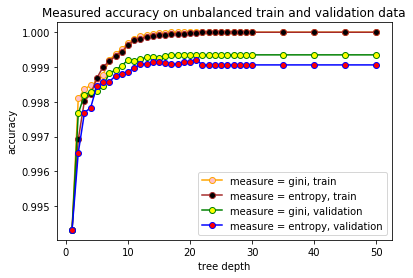

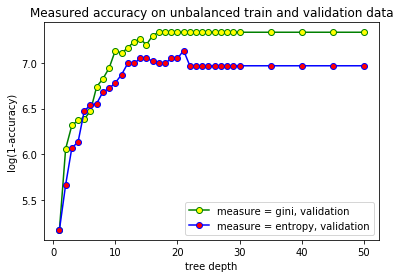

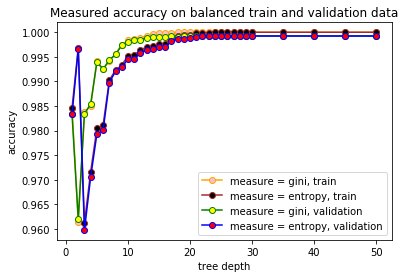

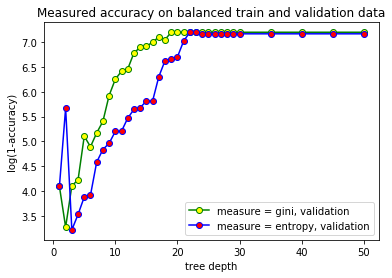

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import results_saving_funcs as rsf

for kow in parameter_dictionary['class_weight'] :
    kind_of_weight = 'unbalanced' if kow is None else kow
    # Train data plot
    plt = rsf.plot_accuracy(parameter_dictionary, ts_dict[kind_of_weight], 'accuracy_tr')
    # Validation data plot
    plt = rsf.plot_accuracy(parameter_dictionary, ts_dict[kind_of_weight], 'accuracy_val')
    plt.ylabel('accuracy')
    plt.title(f'Measured accuracy on {kind_of_weight} train and validation data')
    plt.legend()
    plt.show()
    
    # Validation data plot
    plt = rsf.plot_accuracy(parameter_dictionary, ts_dict[kind_of_weight], 'log_accuracy_val')
    plt.ylabel('log(1-accuracy)')
    plt.title(f'Measured accuracy on {kind_of_weight} train and validation data')
    plt.legend()
    plt.show()

In [10]:
best_params = cff.get_best_parameters(test_scores, parameter_dictionary)

dt_best = DecisionTreeClassifier(criterion=best_params['criterion'],
                                 max_depth=best_params['max_depth'],
                                 class_weight=best_params['class_weight'], random_state=0)

dt_best.fit(X_tr, y_tr)
y_pred_dt = dt_best.predict(X_te)

The parameters for the best model are ...
max_depth = 17
criterion = gini
class_weight = None


In [11]:
! pip install graphviz

In [12]:
path_tree_graphics = './documentation'

# Path for Decision Tree
decision_tree_dot = os.path.join(path_tree_graphics, 'decision_tree.dot')
decision_tree_png = os.path.join(path_tree_graphics, 'decision_tree.png')

from sklearn.tree import export_graphviz

# Export decision tree
dot_data = export_graphviz(
    dt_best, out_file=decision_tree_dot,
    feature_names=df_labelled_feature_matrix.drop(columns=['duplicates']).columns,
    class_names=['unique', 'duplicate'],
    filled=True, rounded=True, proportion=True
)

# Generate image in .png format
! dot -Tpng $decision_tree_dot -o $decision_tree_png

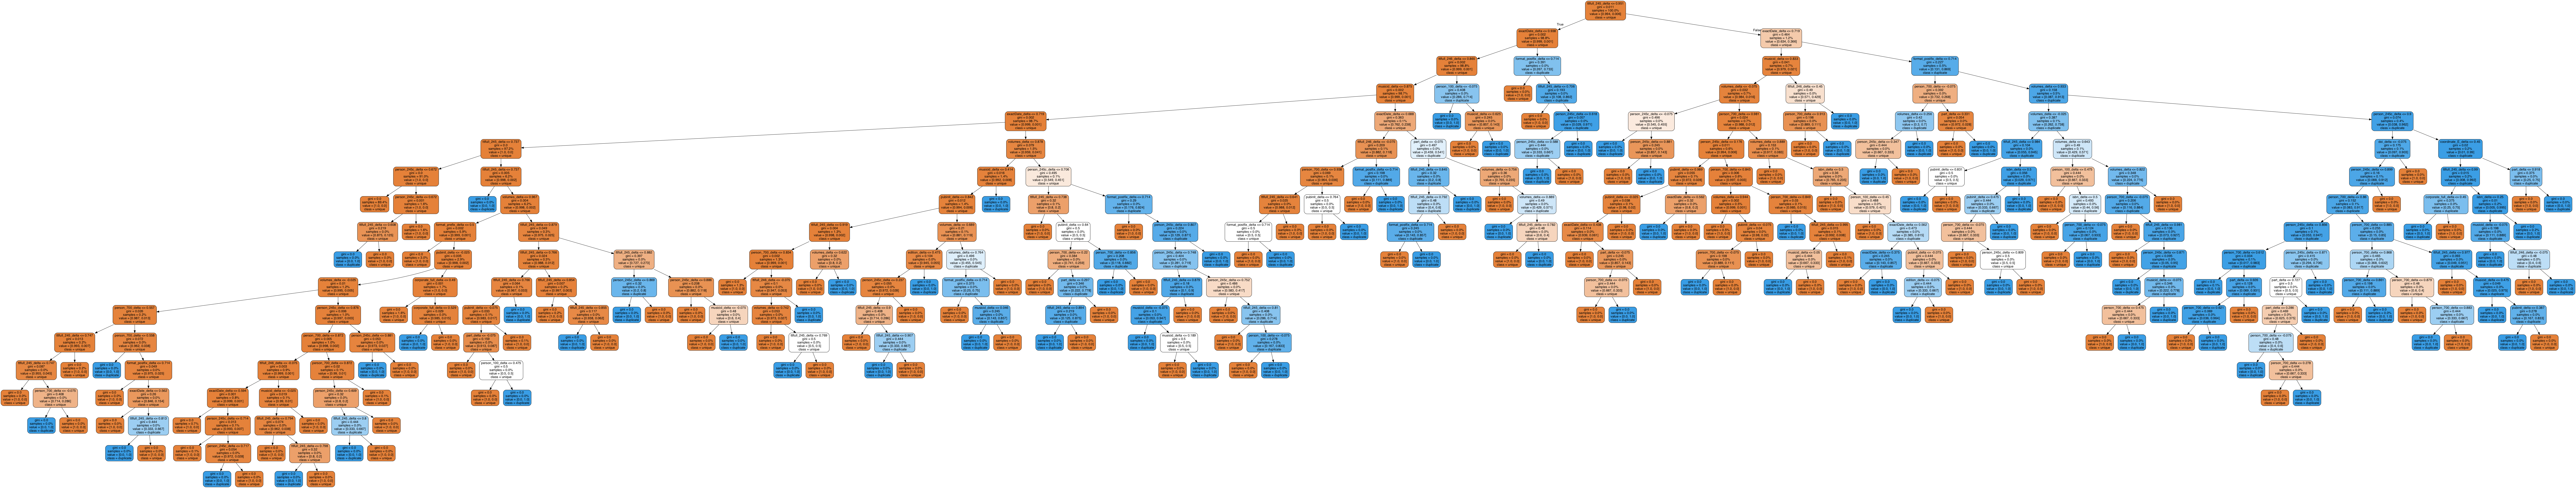

In [13]:
from IPython.display import Image
Image(decision_tree_png)

### Performance Measurement of Decision Tree

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_te, y_pred_dt)

array([[51562,    29],
       [   13,   282]])

In [15]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

print('Score {:.1f}%'.format(100*dt_best.score(X_te, y_te)))
print('Area under the curve {:.1f}% - accuracy {:.1f}% - precision {:.1f}% - recall {:.1f}%'.format(
    100*roc_auc_score(y_te, y_pred_dt),
                100*accuracy_score(y_te, y_pred_dt),
                100*precision_score(y_te, y_pred_dt),
                100*recall_score(y_te, y_pred_dt)
               ))

Score 99.9%
Area under the curve 97.8% - accuracy 99.9% - precision 90.7% - recall 95.6%


In [16]:
import results_analysis_funcs as raf

In [17]:
df_feature_base_full_tr = df_attribute_with_sim_feature.iloc[idx_tr]
df_feature_base_full_te = df_attribute_with_sim_feature.iloc[idx_te]

# Extend display to number of columns of DataFrame
pd.options.display.max_columns = len(df_feature_base_full_te.columns)

df_feature_base_full_te.sort_index().sample(n=10)

duplicates  coordinate_E_delta coordinate_E_x coordinate_E_y  \
168777           0                -0.1                                 
175195           0                -0.1                                 
140609           0                -0.1                                 
240192           0                -0.1                                 
26755            0                -0.1                                 
70983            0                -0.1                                 
243122           0                -0.1                                 
77126            0                -0.1                                 
48871            0                -0.1                                 
102238           0                -0.1                                 

        coordinate_N_delta coordinate_N_x coordinate_N_y  \
168777                -0.1                                 
175195                -0.1                                 
140609                -0.1                                 
240192                -0.1                                 
26755                 -0.1                                 
70983                 -0.1                                 
243122                -0.1                                 
77126                 -0.1                                 
48871                 -0.1                                 
102238                -0.1                                 

        corporate_full_delta  \
168777                 -0.10   
175195                 -0.05   
140609                 -0.10   
240192                 -0.05   
26755                  -0.10   
70983                  -0.10   
243122                 -0.05   
77126                  -0.10   
48871                  -0.05   
102238                 -0.05   

                                         corporate_full_x  \
168777                                                      
175195                                            schweiz   
140609                                                      
240192                                        oper (köln)   
26755                                                       
70983                                                       
243122                  schweizerische normen-vereinigung   
77126                                                       
48871                                                       
102238  metropolitan operaorchestra, metropolitan oper...   

                corporate_full_y  doi_delta doi_x                 doi_y  \
168777                                -0.10                               
175195                                -0.10                               
140609                                -0.05        10.5169/seals-377188   
240192                                -0.05           10.5167/uzh-67756   
26755                                 -0.05        10.5169/seals-377251   
70983                                 -0.10                               
243122                                -0.10                               
77126                                 -0.10                               
48871   herzog august bibliothek      -0.10                               
102238                                -0.10                               

        edition_delta edition_x edition_y  exactDate_delta exactDate_x  \
168777          -0.10                               0.5625    2012aaaa   
175195          -0.05         6                     0.5000    20159999   
140609          -0.10                               0.6250    2005aaaa   
240192          -0.10                               0.3750    19911794   
26755           -0.10                               0.3750    19aaaaaa   
70983           -0.10                               0.2500    2005aaaa   
243122          -0.10                               0.2500    2016aaaa   
77126            0.00         3        11           0.6250    2001aaaa   
48871           -0.10                

In [18]:
idx = {}
idx['true_predicted_uniques'], idx['true_predicted_duplicates'], idx['false_predicted_uniques'], idx['false_predicted_duplicates'] = raf.get_confusion_matrix_indices(y_te, y_pred_dt)

wrong_prediction_groups = ['false_predicted_uniques', 'false_predicted_duplicates']

for i in wrong_prediction_groups :
    rsf.add_wrong_predictions(path_goldstandard, 
                              dt, i, df_feature_base_full_te.loc[idx[i]])

## Decision Tree Classifier with Cross-Validation

In order to reach a model with a strong statistical stability, cross-validation can be used when training the model. This section will use an object $\texttt{GridSearchCV}$ from scikit-learn for this purpose.

### Train/Test Split for Decision Tree CV

When doing cross-validation, the training data is split into training and validation data by the $\texttt{GridSearchCV}$ object from scikit-learn. Therefore, it is sufficient to split the original data into a train and a test data set without any additional splitting of the train data.

In [19]:
X_tr, _, X_te, y_tr, _, y_te, idx_tr, _, idx_te = cff.split_feature_target(
    df_labelled_feature_matrix, 'train_test')

X_tr[:5], y_tr[:5], idx_tr[:5]

(array([[-0.1       , -0.1       , -0.05      , -0.1       , -0.1       ,
          0.25      ,  0.        ,  0.42857143,  0.        , -0.1       ,
          0.16666667, -0.1       , -0.05      , -0.05      ,  0.53888889,
          0.47991021, -0.1       ,  0.59978811, -0.1       ,  0.78333333],
        [-0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
          0.4375    ,  0.        ,  0.11111111,  1.        , -0.1       ,
         -0.05      , -0.1       ,  1.        ,  0.57605284,  0.59184563,
          0.41919192, -0.1       ,  0.7332472 , -0.1       ,  0.        ],
        [-0.1       , -0.1       ,  0.05      , -0.1       , -0.1       ,
          0.25      ,  1.        ,  1.        ,  1.        , -0.1       ,
         -0.1       , -0.1       , -0.05      ,  0.52608873,  0.61453149,
          0.41568627, -0.1       ,  0.51855227, -0.1       ,  0.        ],
        [-0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
          0.5       ,  1.        , 

In [20]:
print(X_tr.shape, y_tr.shape, X_te.shape, y_te.shape)

(207542, 20) (207542,) (51886, 20) (51886,)


### Model Training for Decision Tree CV

The grid search for Decision Tree classifier with cross-validation will be done with the same parameter space like for Decision Tree classifier without cross-validation. In this way, the effect of cross-validation will become obvious.

In [21]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Create cross-validation object with DecisionTreeClassifer
grid_cv = GridSearchCV(DecisionTreeClassifier(random_state=0),
                       param_grid = parameter_dictionary, cv=5
                       , verbose=1
                      )

# Fit estimator
grid_cv.fit(X_tr, y_tr)

# Get the results with 'cv_results_', get parameters with their scores
params = pd.DataFrame(grid_cv.cv_results_['params'])
scores = pd.DataFrame(grid_cv.cv_results_['mean_test_score'], columns=['accuracy_val'])
log_scores = pd.DataFrame(np.log(1-grid_cv.cv_results_['mean_test_score']), columns=['log_accuracy_val'])
scores_std = pd.DataFrame(grid_cv.cv_results_['std_test_score'], columns=['std_accuracy_val'])

# Create a DataFrame of (parameters, score, std) pairs
df_test_scores_dtcv = params.merge(scores, how='inner', left_index=True, right_index=True)
df_test_scores_dtcv = df_test_scores_dtcv.merge(
    scores_std, how='inner', left_index=True, right_index=True).sort_values(
    'accuracy_val', ascending=False)
df_test_scores_dtcv = df_test_scores_dtcv.merge(
    log_scores, how='inner', left_index=True, right_index=True)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:  5.9min finished


In [22]:
df_test_scores_dtcv

class_weight criterion  max_depth  accuracy_val  std_accuracy_val  \
131     balanced   entropy       27.0      0.999297          0.000153   
139     balanced   entropy        NaN      0.999292          0.000151   
138     balanced   entropy       50.0      0.999292          0.000151   
137     balanced   entropy       45.0      0.999292          0.000151   
136     balanced   entropy       40.0      0.999292          0.000151   
..           ...       ...        ...           ...               ...   
72      balanced      gini        3.0      0.979599          0.009513   
108     balanced   entropy        4.0      0.977248          0.009324   
107     balanced   entropy        3.0      0.959767          0.012049   
71      balanced      gini        2.0      0.951354          0.022701   
105     balanced   entropy        1.0      0.923418          0.030449   

     log_accuracy_val  
131         -7.259482  
139         -7.252656  
138         -7.252656  
137         -7.252656  
136         -7.252656  
..                ...  
72          -3.892183  
108         -3.783098  
107         -3.213069  
71          -3.023190  
105         -2.569389  

[140 rows x 6 columns]

In [23]:
dtcv_best = grid_cv.best_estimator_
y_pred_dtcv = dtcv_best.predict(X_te)

### Performance Measurement of Decision Tree CV

In [24]:
confusion_matrix(y_te, y_pred_dtcv)

array([[51576,    15],
       [    9,   286]])

In [25]:
print('Score {:.1f}%'.format(100*dtcv_best.score(X_te, y_te)))
print('Area under the curve {:.1f}% - accuracy {:.1f}% - precision {:.1f}% - recall {:.1f}%'.format(
    100*roc_auc_score(y_te, y_pred_dtcv),
                100*accuracy_score(y_te, y_pred_dtcv),
                100*precision_score(y_te, y_pred_dtcv),
                100*recall_score(y_te, y_pred_dtcv)
               ))

Score 100.0%
Area under the curve 98.5% - accuracy 100.0% - precision 95.0% - recall 96.9%


In [26]:
df_feature_base_full_tr = df_attribute_with_sim_feature.iloc[idx_tr]
df_feature_base_full_te = df_attribute_with_sim_feature.iloc[idx_te]

# Extend display to number of columns of DataFrame
pd.options.display.max_columns = len(df_feature_base_full_te.columns)

df_feature_base_full_te.sort_index().sample(n=10)

duplicates  coordinate_E_delta coordinate_E_x coordinate_E_y  \
166006           0               -0.10                                 
231895           0               -0.10                                 
180945           0               -0.10                                 
28305            0               -0.10                                 
146586           0               -0.05                      e0074147   
173930           0               -0.10                                 
191503           0               -0.10                                 
214169           0               -0.10                                 
104918           0               -0.10                                 
23849            0               -0.05                      e0074147   

        coordinate_N_delta coordinate_N_x coordinate_N_y  \
166006               -0.10                                 
231895               -0.10                                 
180945               -0.10                                 
28305                -0.10                                 
146586               -0.05                      n0460833   
173930               -0.10                                 
191503               -0.10                                 
214169               -0.10                                 
104918               -0.10                                 
23849                -0.05                      n0460833   

        corporate_full_delta  \
166006                 -0.05   
231895                 -0.05   
180945                 -0.10   
28305                  -0.10   
146586                 -0.05   
173930                 -0.10   
191503                 -0.10   
214169                 -0.05   
104918                 -0.10   
23849                  -0.05   

                                         corporate_full_x  \
166006                                                      
231895                  schweizerische normen-vereinigung   
180945                                                      
28305                                                       
146586                                                      
173930                                                      
191503                                                      
214169  trägerverein 600 jahre niklaus von flüe 1417-2017   
104918                                                      
23849                                                       

                                         corporate_full_y  doi_delta  \
166006  interkantonale lehrmittelzentrale (rapperswil,...      -0.05   
231895                                                         -0.10   
180945                                                         -0.10   
28305                                                          -0.10   
146586                   eidgenössische landestopographie      -0.10   
173930                                                         -0.10   
191503                                                         -0.10   
214169                                                         -0.05   
104918                                                         -0.10   
23849                    eidgenössische landestopographie      -0.10   

                     doi_x                 doi_y  edition_delta edition_x  \
166006  10.1093/cid/cir669                                -0.05             
231895                                                    -0.10             
180945                                                    -0.05         6   
28305                                                     -0.10             
146586                                                    -0.05             
173930                                                    -0.05         6   
191503                                                    -0.05             
214169                      10.5169/seals-515321          -0.10             
104918                                     

In [27]:
idx = {}
idx['true_predicted_uniques'], idx['true_predicted_duplicates'], idx['false_predicted_uniques'], idx['false_predicted_duplicates'] = raf.get_confusion_matrix_indices(y_te, y_pred_dtcv)

wrong_prediction_groups = ['false_predicted_uniques', 'false_predicted_duplicates']

for i in wrong_prediction_groups :
    rsf.add_wrong_predictions(path_goldstandard, 
                              dtcv_best, i, df_feature_base_full_te.loc[idx[i]], '_CV')

## Random Forests

Another Ensemble method is Random Forests.

### Train/Test Split for Random Forests

The train/test split for Random Forests will be done the same way like for the Decision Tree classifier.

In [28]:
X_tr, X_val, X_te, y_tr, y_val, y_te, idx_tr, id_val, idx_te = cff.split_feature_target(
    df_labelled_feature_matrix, 'train_validation_test')

X_tr[:5], y_tr[:5], idx_tr[:5]

(array([[-0.1       , -0.1       , -0.1       , -0.05      , -0.1       ,
          0.625     ,  0.        ,  0.42857143,  1.        , -0.1       ,
         -0.05      , -0.05      ,  0.49267677, -0.05      ,  0.54033531,
         -0.05      , -0.1       ,  0.57608486, -0.1       , -0.05      ],
        [-0.1       , -0.1       , -0.1       , -0.1       , -0.05      ,
          0.5       ,  0.        ,  0.42857143,  0.        , -0.1       ,
         -0.1       ,  0.        , -0.05      , -0.05      ,  0.50978836,
         -0.05      , -0.1       ,  0.56688312, -0.1       ,  0.51111111],
        [-0.05      , -0.05      ,  0.06      , -0.1       , -0.1       ,
          0.5       ,  0.        ,  0.42857143,  0.        , -0.1       ,
         -0.1       , -0.05      , -0.1       , -0.1       , -0.05      ,
         -0.05      , -0.05      ,  0.46245348, -0.05      , -0.05      ],
        [-0.1       , -0.1       , -0.05      , -0.1       , -0.1       ,
          0.625     ,  0.        , 

In [29]:
print(X_tr.shape, y_tr.shape, X_te.shape, y_te.shape)

(166033, 20) (166033,) (51886, 20) (51886,)


### Model Training for Random Forests

In [30]:
if execution_mode == 'full' :
    # Tune random forest classifier
    depths = list(range(10, 25))
    depths.append(None)
    parameter_dictionary = {
        'n_estimators' : [8, 10, 25, 40, 50, 75, 100],
        'max_depth' : depths,
        'class_weight' : [None, 'balanced']
    }
elif execution_mode == 'restricted' :
    depths = list(range(20, 22, 24))
    depths.append(None)
    parameter_dictionary = {
        'n_estimators' : [75, 100],
        'max_depth' : depths,
        'class_weight' : [None]
    }

# Grid of values
grid = cff.generate_parameter_grid(parameter_dictionary)

The grid parameters are ...
n_estimators [8, 10, 25, 40, 50, 75, 100]
max_depth [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, None]
class_weight [None, 'balanced']
 => Number of combinations : 224


In [31]:
from sklearn.ensemble import RandomForestClassifier

# Create random forest
rf = RandomForestClassifier(random_state=0) # Leave impurty measure on default value 'gini'

# Save accuracy on test set
test_scores = []
for params_dict in grid :
    test_scores.append(cff.fit_model_measure_scores(rf, params_dict, X_tr, y_tr, X_val, y_val))

# Save measured accuracies
df_test_scores_rf = pd.DataFrame(test_scores).sort_values('accuracy_val', ascending=False)

Fitting with parameters {'class_weight': None, 'max_depth': 10, 'n_estimators': 8}


 => validation score 99.889%
Fitting with parameters {'class_weight': None, 'max_depth': 10, 'n_estimators': 10}


 => validation score 99.908%
Fitting with parameters {'class_weight': None, 'max_depth': 10, 'n_estimators': 25}


 => validation score 99.918%
Fitting with parameters {'class_weight': None, 'max_depth': 10, 'n_estimators': 40}


 => validation score 99.923%
Fitting with parameters {'class_weight': None, 'max_depth': 10, 'n_estimators': 50}


 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'max_depth': 10, 'n_estimators': 75}


 => validation score 99.920%
Fitting with parameters {'class_weight': None, 'max_depth': 10, 'n_estimators': 100}


 => validation score 99.913%
Fitting with parameters {'class_weight': None, 'max_depth': 11, 'n_estimators': 8}


 => validation score 99.908%
Fitting with parameters {'class_weight': None, 'max_depth': 11, 'n_estimators': 10}


 => validation score 99.918%
Fitting with parameters {'class_weight': None, 'max_depth': 11, 'n_estimators': 25}


 => validation score 99.918%
Fitting with parameters {'class_weight': None, 'max_depth': 11, 'n_estimators': 40}


 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'max_depth': 11, 'n_estimators': 50}


 => validation score 99.923%
Fitting with parameters {'class_weight': None, 'max_depth': 11, 'n_estimators': 75}


 => validation score 99.925%
Fitting with parameters {'class_weight': None, 'max_depth': 11, 'n_estimators': 100}


 => validation score 99.925%
Fitting with parameters {'class_weight': None, 'max_depth': 12, 'n_estimators': 8}


 => validation score 99.923%
Fitting with parameters {'class_weight': None, 'max_depth': 12, 'n_estimators': 10}


 => validation score 99.925%
Fitting with parameters {'class_weight': None, 'max_depth': 12, 'n_estimators': 25}


 => validation score 99.925%
Fitting with parameters {'class_weight': None, 'max_depth': 12, 'n_estimators': 40}


 => validation score 99.923%
Fitting with parameters {'class_weight': None, 'max_depth': 12, 'n_estimators': 50}


 => validation score 99.928%
Fitting with parameters {'class_weight': None, 'max_depth': 12, 'n_estimators': 75}


 => validation score 99.925%
Fitting with parameters {'class_weight': None, 'max_depth': 12, 'n_estimators': 100}


 => validation score 99.928%
Fitting with parameters {'class_weight': None, 'max_depth': 13, 'n_estimators': 8}


 => validation score 99.923%
Fitting with parameters {'class_weight': None, 'max_depth': 13, 'n_estimators': 10}


 => validation score 99.923%
Fitting with parameters {'class_weight': None, 'max_depth': 13, 'n_estimators': 25}


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'max_depth': 13, 'n_estimators': 40}


 => validation score 99.930%
Fitting with parameters {'class_weight': None, 'max_depth': 13, 'n_estimators': 50}


 => validation score 99.930%
Fitting with parameters {'class_weight': None, 'max_depth': 13, 'n_estimators': 75}


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'max_depth': 13, 'n_estimators': 100}


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'max_depth': 14, 'n_estimators': 8}


 => validation score 99.942%
Fitting with parameters {'class_weight': None, 'max_depth': 14, 'n_estimators': 10}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 14, 'n_estimators': 25}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 14, 'n_estimators': 40}


 => validation score 99.937%
Fitting with parameters {'class_weight': None, 'max_depth': 14, 'n_estimators': 50}


 => validation score 99.937%
Fitting with parameters {'class_weight': None, 'max_depth': 14, 'n_estimators': 75}


 => validation score 99.942%
Fitting with parameters {'class_weight': None, 'max_depth': 14, 'n_estimators': 100}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 15, 'n_estimators': 8}


 => validation score 99.928%
Fitting with parameters {'class_weight': None, 'max_depth': 15, 'n_estimators': 10}


 => validation score 99.925%
Fitting with parameters {'class_weight': None, 'max_depth': 15, 'n_estimators': 25}


 => validation score 99.925%
Fitting with parameters {'class_weight': None, 'max_depth': 15, 'n_estimators': 40}


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'max_depth': 15, 'n_estimators': 50}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 15, 'n_estimators': 75}


 => validation score 99.937%
Fitting with parameters {'class_weight': None, 'max_depth': 15, 'n_estimators': 100}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 16, 'n_estimators': 8}


 => validation score 99.923%
Fitting with parameters {'class_weight': None, 'max_depth': 16, 'n_estimators': 10}


 => validation score 99.920%
Fitting with parameters {'class_weight': None, 'max_depth': 16, 'n_estimators': 25}


 => validation score 99.937%
Fitting with parameters {'class_weight': None, 'max_depth': 16, 'n_estimators': 40}


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'max_depth': 16, 'n_estimators': 50}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 16, 'n_estimators': 75}


 => validation score 99.945%
Fitting with parameters {'class_weight': None, 'max_depth': 16, 'n_estimators': 100}


 => validation score 99.949%
Fitting with parameters {'class_weight': None, 'max_depth': 17, 'n_estimators': 8}


 => validation score 99.918%
Fitting with parameters {'class_weight': None, 'max_depth': 17, 'n_estimators': 10}


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'max_depth': 17, 'n_estimators': 25}


 => validation score 99.947%
Fitting with parameters {'class_weight': None, 'max_depth': 17, 'n_estimators': 40}


 => validation score 99.947%
Fitting with parameters {'class_weight': None, 'max_depth': 17, 'n_estimators': 50}


 => validation score 99.952%
Fitting with parameters {'class_weight': None, 'max_depth': 17, 'n_estimators': 75}


 => validation score 99.952%
Fitting with parameters {'class_weight': None, 'max_depth': 17, 'n_estimators': 100}


 => validation score 99.947%
Fitting with parameters {'class_weight': None, 'max_depth': 18, 'n_estimators': 8}


 => validation score 99.923%
Fitting with parameters {'class_weight': None, 'max_depth': 18, 'n_estimators': 10}


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'max_depth': 18, 'n_estimators': 25}


 => validation score 99.937%
Fitting with parameters {'class_weight': None, 'max_depth': 18, 'n_estimators': 40}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 18, 'n_estimators': 50}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 18, 'n_estimators': 75}


 => validation score 99.937%
Fitting with parameters {'class_weight': None, 'max_depth': 18, 'n_estimators': 100}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 19, 'n_estimators': 8}


 => validation score 99.930%
Fitting with parameters {'class_weight': None, 'max_depth': 19, 'n_estimators': 10}


 => validation score 99.925%
Fitting with parameters {'class_weight': None, 'max_depth': 19, 'n_estimators': 25}


 => validation score 99.945%
Fitting with parameters {'class_weight': None, 'max_depth': 19, 'n_estimators': 40}


 => validation score 99.947%
Fitting with parameters {'class_weight': None, 'max_depth': 19, 'n_estimators': 50}


 => validation score 99.949%
Fitting with parameters {'class_weight': None, 'max_depth': 19, 'n_estimators': 75}


 => validation score 99.952%
Fitting with parameters {'class_weight': None, 'max_depth': 19, 'n_estimators': 100}


 => validation score 99.952%
Fitting with parameters {'class_weight': None, 'max_depth': 20, 'n_estimators': 8}


 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'max_depth': 20, 'n_estimators': 10}


 => validation score 99.933%
Fitting with parameters {'class_weight': None, 'max_depth': 20, 'n_estimators': 25}


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'max_depth': 20, 'n_estimators': 40}


 => validation score 99.949%
Fitting with parameters {'class_weight': None, 'max_depth': 20, 'n_estimators': 50}


 => validation score 99.954%
Fitting with parameters {'class_weight': None, 'max_depth': 20, 'n_estimators': 75}


 => validation score 99.947%
Fitting with parameters {'class_weight': None, 'max_depth': 20, 'n_estimators': 100}


 => validation score 99.947%
Fitting with parameters {'class_weight': None, 'max_depth': 21, 'n_estimators': 8}


 => validation score 99.925%
Fitting with parameters {'class_weight': None, 'max_depth': 21, 'n_estimators': 10}


 => validation score 99.925%
Fitting with parameters {'class_weight': None, 'max_depth': 21, 'n_estimators': 25}


 => validation score 99.945%
Fitting with parameters {'class_weight': None, 'max_depth': 21, 'n_estimators': 40}


 => validation score 99.952%
Fitting with parameters {'class_weight': None, 'max_depth': 21, 'n_estimators': 50}


 => validation score 99.952%
Fitting with parameters {'class_weight': None, 'max_depth': 21, 'n_estimators': 75}


 => validation score 99.954%
Fitting with parameters {'class_weight': None, 'max_depth': 21, 'n_estimators': 100}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.954%
Fitting with parameters {'class_weight': None, 'max_depth': 22, 'n_estimators': 8}


 => validation score 99.923%
Fitting with parameters {'class_weight': None, 'max_depth': 22, 'n_estimators': 10}


 => validation score 99.933%
Fitting with parameters {'class_weight': None, 'max_depth': 22, 'n_estimators': 25}


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'max_depth': 22, 'n_estimators': 40}


 => validation score 99.949%
Fitting with parameters {'class_weight': None, 'max_depth': 22, 'n_estimators': 50}


 => validation score 99.957%
Fitting with parameters {'class_weight': None, 'max_depth': 22, 'n_estimators': 75}


 => validation score 99.952%
Fitting with parameters {'class_weight': None, 'max_depth': 22, 'n_estimators': 100}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.959%
Fitting with parameters {'class_weight': None, 'max_depth': 23, 'n_estimators': 8}


 => validation score 99.933%
Fitting with parameters {'class_weight': None, 'max_depth': 23, 'n_estimators': 10}


 => validation score 99.937%
Fitting with parameters {'class_weight': None, 'max_depth': 23, 'n_estimators': 25}


 => validation score 99.947%
Fitting with parameters {'class_weight': None, 'max_depth': 23, 'n_estimators': 40}


 => validation score 99.954%
Fitting with parameters {'class_weight': None, 'max_depth': 23, 'n_estimators': 50}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.954%
Fitting with parameters {'class_weight': None, 'max_depth': 23, 'n_estimators': 75}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.952%
Fitting with parameters {'class_weight': None, 'max_depth': 23, 'n_estimators': 100}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.952%
Fitting with parameters {'class_weight': None, 'max_depth': 24, 'n_estimators': 8}


 => validation score 99.928%
Fitting with parameters {'class_weight': None, 'max_depth': 24, 'n_estimators': 10}


 => validation score 99.928%
Fitting with parameters {'class_weight': None, 'max_depth': 24, 'n_estimators': 25}


 => validation score 99.949%
Fitting with parameters {'class_weight': None, 'max_depth': 24, 'n_estimators': 40}


 => validation score 99.957%
Fitting with parameters {'class_weight': None, 'max_depth': 24, 'n_estimators': 50}


 => validation score 99.961%
Fitting with parameters {'class_weight': None, 'max_depth': 24, 'n_estimators': 75}


 => validation score 99.949%
Fitting with parameters {'class_weight': None, 'max_depth': 24, 'n_estimators': 100}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.952%
Fitting with parameters {'class_weight': None, 'max_depth': None, 'n_estimators': 8}


 => validation score 99.925%
Fitting with parameters {'class_weight': None, 'max_depth': None, 'n_estimators': 10}


 => validation score 99.935%
Fitting with parameters {'class_weight': None, 'max_depth': None, 'n_estimators': 25}


 => validation score 99.947%
Fitting with parameters {'class_weight': None, 'max_depth': None, 'n_estimators': 40}


 => validation score 99.954%
Fitting with parameters {'class_weight': None, 'max_depth': None, 'n_estimators': 50}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.957%
Fitting with parameters {'class_weight': None, 'max_depth': None, 'n_estimators': 75}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.952%
Fitting with parameters {'class_weight': None, 'max_depth': None, 'n_estimators': 100}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.952%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 8}


 => validation score 99.733%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 10}


 => validation score 99.745%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 25}


 => validation score 99.733%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 40}


 => validation score 99.742%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 50}


 => validation score 99.745%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 75}


 => validation score 99.745%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100}


 => validation score 99.771%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 11, 'n_estimators': 8}


 => validation score 99.771%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 11, 'n_estimators': 10}


 => validation score 99.783%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 11, 'n_estimators': 25}


 => validation score 99.822%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 11, 'n_estimators': 40}


 => validation score 99.841%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 11, 'n_estimators': 50}


 => validation score 99.834%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 11, 'n_estimators': 75}


 => validation score 99.848%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 11, 'n_estimators': 100}


 => validation score 99.836%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 12, 'n_estimators': 8}


 => validation score 99.843%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 12, 'n_estimators': 10}


 => validation score 99.855%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 12, 'n_estimators': 25}


 => validation score 99.851%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 12, 'n_estimators': 40}


 => validation score 99.848%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 12, 'n_estimators': 50}


 => validation score 99.853%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 12, 'n_estimators': 75}


 => validation score 99.863%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 12, 'n_estimators': 100}


 => validation score 99.877%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 13, 'n_estimators': 8}


 => validation score 99.867%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 13, 'n_estimators': 10}


 => validation score 99.884%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 13, 'n_estimators': 25}


 => validation score 99.892%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 13, 'n_estimators': 40}


 => validation score 99.899%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 13, 'n_estimators': 50}


 => validation score 99.894%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 13, 'n_estimators': 75}


 => validation score 99.892%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 13, 'n_estimators': 100}


 => validation score 99.896%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 8}


 => validation score 99.894%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 10}


 => validation score 99.896%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 25}


 => validation score 99.911%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 40}


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 50}


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 75}


 => validation score 99.913%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 100}


 => validation score 99.908%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 8}


 => validation score 99.908%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 10}


 => validation score 99.913%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 25}


 => validation score 99.930%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 40}


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 50}


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 75}


 => validation score 99.918%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 100}


 => validation score 99.920%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 8}


 => validation score 99.916%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 10}


 => validation score 99.913%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 25}


 => validation score 99.933%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 40}


 => validation score 99.930%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 50}


 => validation score 99.937%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 75}


 => validation score 99.937%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 100}


 => validation score 99.940%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 17, 'n_estimators': 8}


 => validation score 99.911%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 17, 'n_estimators': 10}


 => validation score 99.928%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 17, 'n_estimators': 25}


 => validation score 99.930%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 17, 'n_estimators': 40}


 => validation score 99.928%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 17, 'n_estimators': 50}


 => validation score 99.933%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 17, 'n_estimators': 75}


 => validation score 99.930%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 17, 'n_estimators': 100}


 => validation score 99.933%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 18, 'n_estimators': 8}


 => validation score 99.933%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 18, 'n_estimators': 10}


 => validation score 99.930%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 18, 'n_estimators': 25}


 => validation score 99.937%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 18, 'n_estimators': 40}


 => validation score 99.942%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 18, 'n_estimators': 50}


 => validation score 99.947%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 18, 'n_estimators': 75}


 => validation score 99.947%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 18, 'n_estimators': 100}


 => validation score 99.949%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 19, 'n_estimators': 8}


 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 19, 'n_estimators': 10}


 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 19, 'n_estimators': 25}


 => validation score 99.940%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 19, 'n_estimators': 40}


 => validation score 99.935%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 19, 'n_estimators': 50}


 => validation score 99.937%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 19, 'n_estimators': 75}


 => validation score 99.940%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 19, 'n_estimators': 100}


 => validation score 99.945%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 8}


 => validation score 99.930%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 10}


 => validation score 99.933%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 25}


 => validation score 99.935%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 40}


 => validation score 99.937%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 50}


 => validation score 99.945%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 75}


 => validation score 99.949%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 100}


 => validation score 99.949%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 21, 'n_estimators': 8}


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 21, 'n_estimators': 10}


 => validation score 99.930%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 21, 'n_estimators': 25}


 => validation score 99.940%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 21, 'n_estimators': 40}


 => validation score 99.937%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 21, 'n_estimators': 50}


 => validation score 99.942%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 21, 'n_estimators': 75}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.940%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 21, 'n_estimators': 100}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.952%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 22, 'n_estimators': 8}


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 22, 'n_estimators': 10}


 => validation score 99.935%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 22, 'n_estimators': 25}


 => validation score 99.937%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 22, 'n_estimators': 40}


 => validation score 99.945%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 22, 'n_estimators': 50}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.947%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 22, 'n_estimators': 75}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.952%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 22, 'n_estimators': 100}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.954%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 23, 'n_estimators': 8}


 => validation score 99.930%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 23, 'n_estimators': 10}


 => validation score 99.935%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 23, 'n_estimators': 25}


 => validation score 99.947%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 23, 'n_estimators': 40}


 => validation score 99.940%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 23, 'n_estimators': 50}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.954%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 23, 'n_estimators': 75}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.957%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 23, 'n_estimators': 100}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.954%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 24, 'n_estimators': 8}


 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 24, 'n_estimators': 10}


 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 24, 'n_estimators': 25}


 => validation score 99.942%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 24, 'n_estimators': 40}


 => validation score 99.947%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 24, 'n_estimators': 50}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.952%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 24, 'n_estimators': 75}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.949%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 24, 'n_estimators': 100}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.952%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 8}


 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 10}


 => validation score 99.933%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 25}


 => validation score 99.945%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 40}


 => validation score 99.947%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 50}


 => validation score 99.947%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 75}


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


 => validation score 99.949%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 100}


 => validation score 99.949%


/Users/andreas/conda/capstone-proposal-ads-ml-c5-s1-1365-585/classifier_fitting_funcs.py:29: RuntimeWarning: divide by zero encountered in log
  param_dict['log_accuracy_tr'] = -np.log(1-model.score(X_tr, y_tr))


In [32]:
best_params = cff.get_best_parameters(test_scores, parameter_dictionary)

# Create a decision tree
rf_best = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                 max_depth=best_params['max_depth'],
                                 class_weight=best_params['class_weight'],
                                 random_state=0
                                )

# Fit estimator
rf_best.fit(X_tr, y_tr)
y_pred_rf = rf_best.predict(X_te)

The parameters for the best model are ...
n_estimators = 50
max_depth = 24
class_weight = None


For Random Forests an attribute is provided which returns an array, indicating the feature importances. The higher the value, the more important the feature.

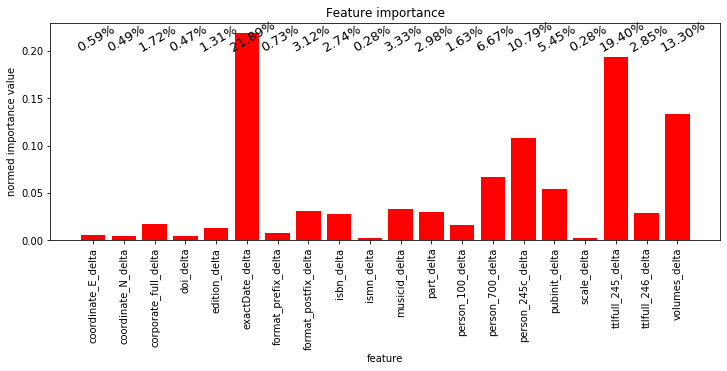

In [33]:
x_ticks = df_labelled_feature_matrix.drop(columns=['duplicates']).columns

plt.figure(figsize=(12,4))
plt.bar(x_ticks, rf_best.feature_importances_, color='red')
for i in range(len(x_ticks)):
    plt.text(i-0.6, 2/10, f'{rf_best.feature_importances_[i]*100:.2f}%',
             color='black', rotation=30, fontsize=13)
plt.xticks(rotation='vertical')
plt.title('Feature importance')
plt.xlabel('feature')
plt.ylabel('normed importance value')
plt.show()

### Performance Measurement of Random Forests

In [34]:
confusion_matrix(y_te, y_pred_rf)

array([[51575,    16],
       [   13,   282]])

In [35]:
print('Score {:.1f}%'.format(100*rf_best.score(X_te, y_te)))
print('Area under the curve {:.1f}% - accuracy {:.1f}% - precision {:.1f}% - recall {:.1f}%'.format(
    100*roc_auc_score(y_te, y_pred_rf),
                100*accuracy_score(y_te, y_pred_rf),
                100*precision_score(y_te, y_pred_rf),
                100*recall_score(y_te, y_pred_rf)
               ))

Score 99.9%
Area under the curve 97.8% - accuracy 99.9% - precision 94.6% - recall 95.6%


In [36]:
idx = {}
idx['true_predicted_uniques'], idx['true_predicted_duplicates'], idx['false_predicted_uniques'], idx['false_predicted_duplicates'] = raf.get_confusion_matrix_indices(y_te, y_pred_rf)

wrong_prediction_groups = ['false_predicted_uniques', 'false_predicted_duplicates']

for i in wrong_prediction_groups :
    rsf.add_wrong_predictions(path_goldstandard, 
                              rf, i, df_feature_base_full_te.loc[idx[i]])

## Results Handover

The final results will be assessed with the help of the same test data for all three models of this chapter. The train/test split will not be repeated here, as all train/test split calls of this chapter have generated the same test data set, due to fixing $\texttt{random}\_\texttt{state}=0$.

In [37]:
rsf.add_result_to_results(path_goldstandard,
                          df_test_scores_dt, dt_best, X_te, y_te, y_pred_dt)
rsf.add_result_to_results(path_goldstandard,
                          df_test_scores_dtcv, dtcv_best, X_te, y_te, y_pred_dtcv, '_CV')
rsf.add_result_to_results(path_goldstandard,
                          df_test_scores_rf, rf_best, X_te, y_te, y_pred_rf)